# Installations and Imports

In [ ]:
#utilizing the transformers package - typically need to install at every colab session 
!pip install transformers

In [2]:
from glob import glob
from tqdm import tqdm
import pandas as pd
import random
import json
import os


import torch
from torch.utils.data import Dataset, DataLoader
from transformers import LayoutLMForTokenClassification
from transformers import LayoutLMModel, LayoutLMConfig, LayoutLMTokenizer
from torch.nn.functional import pad

from google.colab import auth

import numpy as np
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont

from torch.nn import CrossEntropyLoss

In [ ]:
#Checking the torch version
torch.__version__

'1.8.1+cu101'

# Dividing into Test and Train

In [1]:
# original folder organization; if not using this format, adjust divide_test_train() and recombine_test_train() accordingly
# apm
# ├── annotations/
# ├── metadata/
# ├── images/
# └── train/
#    ├── annotations/
#    ├── metadata/
#    ├── images/
# └── test/
#    ├── annotations/
#    ├── metadata/
#    ├── images/
# └── errors/



In [ ]:
def divide_test_train():
    # Function to divide data in test train
    annotations_files = sorted(glob('apm/annotations/' + '*.csv'))
    metadata_files = sorted(glob('apm/metadata/' + '*.json'))
    image_files = sorted(glob('apm/images/' + '*.png'))
    
    for annotation, metadata, image in zip(annotations_files, metadata_files, image_files):
        # Put annotation in train with prob .8 and in test with prob .2
        rand_number = random.uniform(0,1)
        if rand_number <= .8:  
            os.rename(annotation, "apm/train/annotations/{}".format(annotation[-40:]))
            os.rename(metadata, "apm/train/metadata/{}".format(metadata[-41:]))
            os.rename(image, "apm/train/images/{}".format(image[-40:]))
        else:
            os.rename(annotation, "apm/test/annotations/{}".format(annotation[-40:]))
            os.rename(metadata, "apm/test/metadata/{}".format(metadata[-41:]))
            os.rename(image, "apm/test/images/{}".format(image[-40:]))

In [ ]:
divide_test_train()

In [ ]:
# Sanity check - printing the number of items in the training and testing files
annotations_train_files = sorted(glob('apm/train/annotations/' + '/*.csv'))
annotations_test_files = sorted(glob('apm/test/annotations/' + '/*.csv'))
counter_train = 0
for train_example in annotations_train_files:
    counter_train += 1

counter_test = 0
for test_example in annotations_test_files:
    counter_test += 1

print(counter_train, counter_test, counter_train+counter_test)

6786 605 7391


In [ ]:
# resetting training and test data back into original folders - use as needed
def recombine_test_train():
    # move test data back into original folders
    annotations_files = sorted(glob('apm/test/annotations/' + '*.csv'))
    metadata_files = sorted(glob('apm/test/metadata/' + '*.json'))
    image_files = sorted(glob('apm/test/images/' + '*.png'))
    
    for annotation, metadata, image in zip(annotations_files, metadata_files, image_files):
        os.rename(annotation, "apm/annotations/{}".format(annotation[-40:]))
        os.rename(metadata, "apm/metadata/{}".format(metadata[-41:]))
        os.rename(image, "apm/images/{}".format(image[-40:]))
    
    # move train data back into original folders
    annotations_files = sorted(glob('apm/train/annotations/' + '*.csv'))
    metadata_files = sorted(glob('apm/train/metadata/' + '*.json'))
    image_files = sorted(glob('apm/train/images/' + '*.png'))
    
    for annotation, metadata, image in zip(annotations_files, metadata_files, image_files):
        os.rename(annotation, "apm/annotations/{}".format(annotation[-40:]))
        os.rename(metadata, "apm/metadata/{}".format(metadata[-41:]))
        os.rename(image, "apm/images/{}".format(image[-40:]))
        

In [ ]:
# recombine_test_train()

# Dataloader

In [ ]:
labels = ["Other","Total", "Invoice_ID"]
label_map = {i: label for i, label in enumerate(labels)}
type(label_map)

dict

In [ ]:
# Define Tokenizer
tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased", max_seq_length = 512)

In [ ]:
#to store a tokenized 
class Invoice_Tokenized():
  def __init__ (self, csv_name, encoding, bbox, token_labels, token_actual_boxes):
    self.input_ids = encoding["input_ids"]
    self.attention_mask = encoding["attention_mask"]
    self.token_type_ids = encoding["token_type_ids"]
    self.bbox = bbox
    self.token_labels = token_labels
    self.csv_name = csv_name
    self.token_actual_boxes = token_actual_boxes
    self.items = [self.input_ids, self.token_type_ids, self.attention_mask, self.token_labels, self.bbox, self.csv_name, self.token_actual_boxes]
  
  def __getitem__(self, idx):
    order = ["input_ids", "token_type_ids", "attention_mask", "token_labels", "bbox", "csv", "token_actual_boxes"]
    return order[idx], self.items[idx]

In [ ]:
#for new Dataloader
class total_invoiceid_not_found(Exception):
    pass

# the data we utilized had the ground truth in a json metadata file where the 
# InvoiceID was referenced as IMI_REFERENCE and the Total amount was referenced
# as AMOUNT
def preprocess_indiv_files(csv, annotation, metadata):
        '''
        input: 
        csv : name of the annotations csv file; to ensure that the invoice files and the data are corresponding properly
        annotation: dataframe that contains all the text and the relative location bounding boxes for a singular invoice;
        metadata: json file that contains the ground truth values as provided to the team; Total amount: AMOUNT; InvoiceID: INVOICE_CHECK_MEMO
        
        concatenates a ground truth label column to the annotation dataframe:
        '''   
        
        annotation['Label'] = None
        find_invoice = False
        find_total = False
        
        for i in annotation.index:
            if annotation.loc[i,'content'] == str(metadata["INVOICE_CHECK_MEMO"]):
                find_invoice = True
                annotation.loc[i,'Label'] = "Invoice_ID"
            elif annotation.loc[i,'content'] == str(metadata["AMOUNT"]):
                find_total = True
                annotation.loc[i,'Label'] = "Total"
            elif annotation.loc[i,'content'] == "$" + str(metadata["AMOUNT"]): 
                find_total = True
                annotation.loc[i,'Label'] = "Total"
                annotation.loc[i,'content'] = annotation.loc[i,'content'][1:]
            else:
                annotation.loc[i,'Label'] = "Other"
        
        if not (find_total or find_invoice):
            raise total_invoiceid_not_found()
            
        words = []
        token_boxes = [[0,0,0,0]]
        token_actual_boxes = [[0,0, 0, 0]] 
        token_labels = [-100] # CLS token
        
        annotation = annotation.to_numpy()
        
        # many of the bounding boxes in the invoices don't follow the top_left_x < bottom_right_x and top_left_y > bottom_right_y rule; 
        # filtering those cases out
        for row in annotation:   
            if(row[1] - row[0] < 0 or row[3] - row[2] < 0 or row[0] > row[4]\
                    or row[1] > row[4] or row[2] > row[5] or row[3] > row[5]):
                continue
            word_tokens = tokenizer.tokenize(row[6])

            # truncate overall sequence length to 512 (starting token + 510 + ending token)
            # this is due to the BERT limit of 512 sequence length
            if(len(token_boxes) + len(word_tokens) >= 511):
                break
            words.append(row[6])
            if not(row[1] - row[0] > 0) or not(row[3] - row[2] > 0) or\
              not(int(row[0]/row[4]*1000) <= 1000 and int(row[0]/row[4]*1000)>0) or\
              not (int(row[2]/row[5]*1000) <= 1000 and int(row[2]/row[5]*1000) > 0) or\
              not (int(row[1]/row[4]*1000) <= 1000 and int(row[1]/row[4]*1000) > 0) or\
              not (int(row[3]/row[5]*1000) <= 1000 and int(row[3]/row[5]*1000) > 0):
                continue
            assert (row[1] - row[0]) > 0, "Wrong bounding boxes-x {} {}".format(row[1]-row[0], row)
            assert (row[3] - row[2]) > 0, "Wrong bounding boxes-y {} {}".format(row[3]-row[2], row)
            actual_box = [row[0], row[2], row[1], row[3]]
            assert (int(row[0]/row[4]*1000) <= 1000 and int(row[0]/row[4]*1000)>0)
            assert (int(row[2]/row[5]*1000) <= 1000 and int(row[2]/row[5]*1000) > 0)
            assert (int(row[1]/row[4]*1000) <= 1000 and int(row[1]/row[4]*1000) > 0)
            assert (int(row[3]/row[5]*1000) <= 1000 and int(row[3]/row[5]*1000) > 0)
            box = [int(row[0]/row[4]*1000), int(row[2]/row[5]*1000), int(row[1]/row[4]*1000), int(row[3]/row[5]*1000)]
            token_boxes.extend([box] * len(word_tokens))
            token_actual_boxes.extend([actual_box] * len(word_tokens))

            #Labels of 0: Other; 1: Total; 2: Invoice_ID
            token_labels.extend([2 if row[-1]=="Invoice_ID" else (1 if row[-1]=="Total" else 0)] * len(word_tokens))
          

        encoding = tokenizer(' '.join(words), padding="max_length", truncation=True, return_tensors='pt')
        
        token_boxes = token_boxes + [[1000, 1000, 1000, 1000]]+[[0,0,0,0]]*(512-len(token_boxes)-1)
        token_actual_boxes = token_actual_boxes + [[1000, 1000, 1000, 1000]]+[[0,0,0,0]]*(512-len(token_actual_boxes)-1)
        token_labels.append(0) # SEP token
        if(len(token_labels)<512):
            token_labels.extend([-100]*(512-len(token_labels)))
        return Invoice_Tokenized(csv, encoding, torch.tensor([token_boxes]), torch.tensor([token_labels]), torch.tensor([token_actual_boxes]))  #encoding, bbox, token_labels

In [1]:
def preprocess(annotations_folder, metadata_folder):
        '''
        input: annotations_folder_path, metadata_folder_path
        assumes that the corresponding annotations and metadata are present and have the same order in their directories
        '''
        annotations_files = sorted(glob(annotations_folder + '/*.csv'))
        metadata_files = sorted(glob(metadata_folder + '/*.json'))
        annotations = []
        #process each individual file; if malformed file or no corresponding InvoiceID AND Total ground truth, then skip
        for idx, csv in enumerate(annotations_files):  
          try:       
            annotation = pd.read_csv(csv, index_col=0)
            metadata = json.load(open(metadata_files[idx], "r"))
            invoice = preprocess_indiv_files(csv, annotation, metadata)
            
            annotations.append(invoice)
          except total_invoiceid_not_found:
            print("IDX WITH NO Invoice_ID and NO Total: ", idx)
            continue
          except:
            print("IDX WHERE ERRORING: ", idx)
            continue
        return annotations


In [ ]:
#new DataLoader

# Define pytorch Dataset

class InvoiceDataset(Dataset):

    def __init__(self, root_directory):
        self.annotations_folder = root_directory + '/annotations/'
        self.metadata_folder = root_directory + '/metadata/'
        
        self.annotations = preprocess(self.annotations_folder, self.metadata_folder)
        self.sequence_length = 512
              
    def __len__(self):
        return len(self.annotations)
    

    def __getitem__(self, idx):
        item = self.annotations[idx]
        return item[0][1], item[1][1], item[2][1], item[3][1], item[4][1], item[5][1], item[6][1]   #input_ids, token_type_ids, attention_mask, token_labels, bbox


# Model Code

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=3)
model.to(device)

In [ ]:
# Initialize Dataset
root_directory_train = './apm/train'

#creating dataloader for the model as to not overwhelm the model with too much data at one time
invoice_dataset = InvoiceDataset(root_directory_train)
train_dataloader = DataLoader(invoice_dataset, batch_size=1) #can adjust batch size

In [ ]:
print(len(train_dataloader), device)

6360 cuda


In [ ]:
# Training

from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 5 #number of epochs
loss_per_100 = []
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

count_wrong_forwards = 0
#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
    for batch in tqdm(train_dataloader, desc="Training"):
        optimizer.zero_grad()
        #input_ids, token_type_ids, attention_mask, token_labels, bbox
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        token_labels = batch[3].to(device)
        bbox = batch[4].to(device).squeeze(0)
        invoice_name = batch[5]
        try:
            outputs = model(input_ids = input_ids.squeeze(0), token_type_ids = token_type_ids.squeeze(0),\
                            attention_mask = attention_mask.squeeze(0),\
                            bbox = bbox, labels = token_labels.squeeze(0))        
        except:
            count_wrong_forwards += 1
            print("This invoice has an error: ", invoice_name)
            print(bbox.type(), bbox.shape)
            continue
        loss = outputs.loss

        # print loss every 100 steps
        if global_step % 100 == 0:
            loss_per_100.append(loss.item())
            print(f"Loss after {global_step} steps: {loss.item()}")

        # backward pass 
        loss.backward()

        # update
        optimizer.step()
        
        global_step += 1

In [ ]:
print("Number or examples that weren't processed: ", int(count_wrong_forwards/num_train_epochs))
print("Number of steps: ", global_step)

Number or examples that weren't processed:  0
Number of steps:  31800


In [ ]:
# Save model so that don't need to rerun model training every time it's utilized
torch.save(model.state_dict(), "tot_id_model")

318 318


Text(0.5, 1.0, 'Loss over training steps')

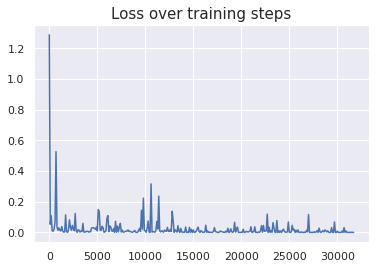

In [ ]:
#Visualizing the loss over the training steps
sns.set()
loss_per_100 = np.array(loss_per_100)
steps_per_100 = np.arange(0, len(loss_per_100)*100, 100)
print(len(loss_per_100), len(steps_per_100))
sns.lineplot(x=steps_per_100, y=loss_per_100).set_title("Loss over training steps", fontsize=15)

# Evaluation

In [ ]:
# Load model
model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("tot_id_model"))  
model.to(device)
model.eval()

In [ ]:
#creating dataloader for the evaluation with test data
root_directory_test = "./apm/test/"
invoice_dataset_test = InvoiceDataset(root_directory_test)
eval_dataloader = DataLoader(invoice_dataset_test, batch_size=1)

In [ ]:
len(eval_dataloader)

## Ternary Labels 

In [ ]:
eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None
num_not_used = 0

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        token_labels = batch[3].to(device)
        bbox = batch[4].to(device)
        invoice_name = batch[5]

        try:
            outputs = model(input_ids = input_ids.squeeze(0), token_type_ids = token_type_ids.squeeze(0),\
                            attention_mask = attention_mask.squeeze(0), labels = token_labels.squeeze(0),\
                            bbox = bbox.squeeze(0))
        except:
            print(bbox, invoice_name)
            num_not_used += 1
            continue
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits
        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1
        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = token_labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, token_labels.detach().cpu().numpy(), axis=0)

print(num_not_used)
# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
print("Eval_loss: ", round(eval_loss, 3))
preds = np.argmax(preds, axis=2) # getting a singular prediction for each bounding box in each invoice from the evaluation data
out_label_ids = out_label_ids.squeeze(1)

Evaluating: 100%|██████████| 573/573 [00:20<00:00, 27.40it/s]

0
Eval_loss:  0.013


In [ ]:
labels = ["Total","Invoice_ID", "Other"]
label_map = {i: label for i, label in enumerate(labels)}
pad_token_label_id = CrossEntropyLoss().ignore_index
print(labels, label_map, pad_token_label_id)

['Total', 'Invoice_ID', 'Other'] {0: 'Total', 1: 'Invoice_ID', 2: 'Other'} -100


In [ ]:
#getting the corresponding labels for the numeric classifications
out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]): #for each invoice
    for j in range(out_label_ids.shape[1]): #for each point in the invoice
        if (out_label_ids[i][j] != pad_token_label_id): 
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

print(eval_loss)
print(num_not_used)

0.01266757901004202
0


In [ ]:
np.any(preds == 0) and np.any(preds == 1) and np.any(preds == 2) #sanity check to ensure the model is working properly

True

In [ ]:
matrix = np.zeros((3,3)) #confusion matrix where rows are predicted and columns are actual

for i in range(out_label_ids.shape[0]): #for each invoice
  for j in range(out_label_ids.shape[1]): #for each point in the invoice
    if (out_label_ids[i][j] != pad_token_label_id): #if doesn't equal the dummy variable
      matrix[ preds[i][j] , out_label_ids[i][j] ] +=1

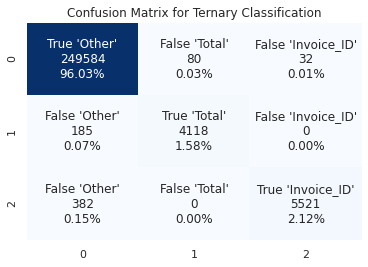

In [ ]:
#Visualizing the confusion matrix
sns.set()
cf_matrix = matrix.flatten()
group_names = [   "True 'Other'",  "False 'Total'", "False 'Invoice_ID'",  \
                  "False 'Other'", "True 'Total'",  "False 'Invoice_ID'",  \
                  "False 'Other'", "False 'Total'", "True 'Invoice_ID'"    ]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
cnfmatr = sns.heatmap(matrix, annot=labels, fmt="", cmap="Blues", cbar = False)
cnfmatr = cnfmatr.set_title("Confusion Matrix for Ternary Classification")

In [ ]:
#metrics for Total
matrix_without_total = np.delete(matrix, 1,1)
matrix_without_total = np.delete(matrix_without_total, 1,0)

tot_true_positives = matrix[1,1]
tot_true_negatives = np.sum(matrix_without_total)
tot_false_positives = np.sum(matrix[1,:]) - matrix[1,1]
tot_false_negatives = np.sum(matrix[:,1]) - matrix[1,1]

tot_precision = tot_true_positives/(tot_true_positives+tot_false_positives)
tot_recall = tot_true_positives/(tot_true_positives+tot_false_negatives)
tot_accuracy = (tot_true_positives+tot_true_negatives)/(tot_true_positives+tot_true_negatives+tot_false_negatives+tot_false_positives)
tot_f1 = 2*(tot_precision*tot_recall)/(tot_precision+tot_recall)

# print(matrix)


print("Metrics for Total Values")
print("Precision:", round(tot_precision,3))
print("Recall:", round(tot_recall,3))
print("Accuracy:", round(tot_accuracy,3))
print("F1:", round(tot_f1,3))


print("\n--------\n")
#metrics for InvoiceID
id_true_positives = matrix[2,2]

id_true_positives = matrix[2,2]
id_true_negatives = np.sum(matrix[:2,:2])
id_false_positives = np.sum(matrix[2,:2])
id_false_negatives = np.sum(matrix[:2,2])

id_precision = id_true_positives/(id_true_positives+id_false_positives)
id_recall = id_true_positives/(id_true_positives+id_false_negatives)
id_accuracy = (id_true_positives+id_true_negatives)/(id_true_positives+id_true_negatives+id_false_negatives+id_false_positives)
id_f1 = 2*(id_precision*id_recall)/(id_precision+id_recall)


print("Metrics for InvoiceID Values")
print("Precision:", round(id_precision,3))
print("Recall:", round(id_recall,3))
print("Accuracy:", round(id_accuracy,3))
print("F1:", round(id_f1,3))

Metrics for Total Values
Precision: 0.957
Recall: 0.981
Accuracy: 0.999
F1: 0.969

--------

Metrics for InvoiceID Values
Precision: 0.935
Recall: 0.994
Accuracy: 0.998
F1: 0.964


In [ ]:
#Printing the True/False Postitives/Negatives for Both Classifications
print(matrix, '\n')
print("tot_true_negatives: ",tot_true_negatives)
print("tot_true_positives: ", tot_true_positives)
print("tot_false_negatives: ", tot_false_negatives)
print("tot_false_positives: ",tot_false_positives)
print()
print("id_true_negatives: ",id_true_negatives)
print("id_true_positives: ", id_true_positives)
print("id_false_negatives: ", id_false_negatives)
print("id_false_positives: ",id_false_positives)

[[2.49584e+05 8.00000e+01 3.20000e+01]
 [1.85000e+02 4.11800e+03 0.00000e+00]
 [3.82000e+02 0.00000e+00 5.52100e+03]] 

tot_true_negatives:  255519.0
tot_true_positives:  4118.0
tot_false_negatives:  80.0
tot_false_positives:  185.0

id_true_negatives:  253967.0
id_true_positives:  5521.0
id_false_negatives:  32.0
id_false_positives:  382.0


4118.0 185.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, "Invoice 'Total' Value Positive Classifications")

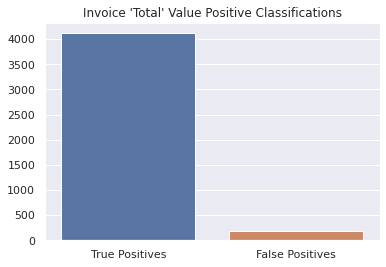

In [ ]:
#Visualizing the 'Total' Positives - can alter to visualize Positives/Negatives for  Total/Invoice_ID
print(tot_true_positives, tot_false_positives)
labels_p = np.array(["True Positives", "False Positives"])
values_p = np.array([tot_true_positives, tot_false_positives])
tot_pos = sns.barplot(labels_p, values_p)
tot_pos = tot_pos.set_title("Invoice 'Total' Value Positive Classifications")
tot_pos

## Visualize prediction of Random Image

In [ ]:
# Code to generate random number and get that image; if errors, then rerun cell
import random
batch = None
count = 0
rand_integer = random.randint(0, len(eval_dataloader))
print("Random integer is: ", rand_integer)
for batch in eval_dataloader:
    if count == rand_integer:
        break
    count += 1

input_ids = batch[0].to(device)
token_type_ids = batch[1].to(device)
attention_mask = batch[2].to(device)
token_labels = batch[3].to(device)
bbox = batch[4].to(device)
invoice_name = batch[5]
token_actual_boxes = batch[6].to(device)

outputs = model(input_ids = input_ids.squeeze(0), token_type_ids = token_type_ids.squeeze(0),\
                attention_mask = attention_mask.squeeze(0), bbox = bbox.squeeze(0), output_attentions=True)

token_actual_boxes = token_actual_boxes.squeeze(0).squeeze(0).tolist()[:-1]
input_ids = input_ids.squeeze(0).squeeze(0).tolist()
invoice_id = invoice_name[0][24:-4]
print(invoice_id)

image = Image.open("apm/test/images/" + invoice_id + ".png")
image = image.convert("RGB")


cls_token_box=[0, 0, 0, 0]
sep_token_box=[1000, 1000, 1000, 1000]
pad_token_box=[0, 0, 0, 0]

print("TOTAL = ", json.load(open("apm/test/metadata/" + invoice_id + ".json",))['AMOUNT'])
print("INVOICE_ID = ", json.load(open("apm/test/metadata/" + invoice_id + ".json",))['INVOICE_CHECK_MEMO'])

token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level

word_level_predictions = [] # let's turn them into word level predictions
final_boxes = []
for id, token_pred, box in zip(input_ids, token_predictions, token_actual_boxes):
    if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                           tokenizer.sep_token_id, 
                                                          tokenizer.pad_token_id]):
    # skip prediction + bounding box
        continue
    else:
        word_level_predictions.append(token_pred)
        final_boxes.append(box)

# Visualize image
labels = ["Other", "Total", "Invoice_ID"]
label_map = {i: label for i, label in enumerate(labels)}


# print(label_map)
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    if label == 'Other':
        return "other"
    elif label == "Total":
        return "total"
    elif label == "Invoice_ID":
        return "invoice_id"

label2color = {'other':'white', 'total':'blue', 'invoice_id':'red'}

for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image.thumbnail((800, 800))
image

## Visualizing errors

In [ ]:
'''
Save images with bounding boxes showing 
where there are errors in ./apm/errors/
'''

labels = ["other", "total", "false negative", "false positive"]
label_map = {i: label for i, label in enumerate(labels)}

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    if label != 'other':
        return label
    else:
        return "other"

label2color = {'other':'blue', 'total':'red', 'false negative': 'black', 'false positive':'orange'}

cls_token_box=[0, 0, 0, 0]
sep_token_box=[1000, 1000, 1000, 1000]
pad_token_box=[0, 0, 0, 0]
false_negative_label = 2
false_positive_label = 3

for batch in eval_dataloader:
        
    input_ids = batch[0].to(device)
    token_type_ids = batch[1].to(device)
    attention_mask = batch[2].to(device)
    token_labels = batch[3].to(device)
    bbox = batch[4].to(device)
    invoice_name = batch[5][0][24:-4]
    token_actual_boxes = batch[6].to(device)
    outputs = model(input_ids = input_ids.squeeze(0), token_type_ids = token_type_ids.squeeze(0), attention_mask = attention_mask.squeeze(0))

    token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level
    token_actual_boxes = token_actual_boxes.squeeze(0).squeeze(0).tolist()[:-1]
    token_labels = token_labels.squeeze().tolist()
    
    input_ids = input_ids.squeeze(0).squeeze(0).tolist()
    
    word_level_predictions = [] # let's turn them into word level predictions
    final_boxes = []
    errors = []
    errors_boxes = []
    found_error = False
    for id, token_pred, box, token_label in zip(input_ids, token_predictions, token_actual_boxes, token_labels):
        if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                               tokenizer.sep_token_id, 
                                                              tokenizer.pad_token_id]):
            # skip prediction + bounding box
            continue
        else:
            # If we have an error we can label it differently
            if token_pred != token_label:
                found_error = True
                errors.append(tokenizer.decode([id]))
                errors_boxes.append(box)
                if token_pred == 0:
                    # Predicted negative but it's positive
                    word_level_predictions.append(false_negative_label)
                elif token_pred == 1:
                    # Predicted positive but it's negative
                    word_level_predictions.append(false_positive_label)
                final_boxes.append(box)
                # print("Predicted: ", label_map[token_pred], " Label: ", label_map[token_label], " Content: ", tokenizer.decode([id]))
                continue
                
            word_level_predictions.append(token_pred)
            final_boxes.append(box)

    if found_error:
        # Visualizing predictions
        image = Image.open("./apm/images/" + invoice_name + ".png")
        image = image.convert("RGB")

        draw = ImageDraw.Draw(image)
        font = ImageFont.load_default()

        for prediction, box in zip(word_level_predictions, final_boxes):
            predicted_label = iob_to_label(label_map[prediction]).lower()
            draw.rectangle(box, outline=label2color[predicted_label])
            draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
        
        # If we have an error, save image in ./apm/errors/
        image.save("./apm/errors/" + invoice_name + ".png")
